In [164]:
import pandas as pd

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

# Orm
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine

In [165]:
engine = create_engine('sqlite:///db.sqlite')
Session = sessionmaker(bind=engine)
session = Session()

df = pd.read_sql('LostItem', con = engine)

In [166]:
kept_features = ['date', 'type_objet']
df = df[kept_features]
df['cnt'] = 1

In [167]:
display(df,
df.dtypes)

,date,type_objet,cnt
0,2017-12-31T11:45:16+00:00,"Bagagerie: sacs, valises, cartables",1
1,2017-12-31T08:35:34+00:00,"Porte-monnaie / portefeuille, argent, titres",1
2,2017-12-31T08:28:26+00:00,Pièces d'identités et papiers personnels,1
3,2017-12-31T08:05:06+00:00,"Porte-monnaie / portefeuille, argent, titres",1
4,2017-12-31T07:58:14+00:00,"Bagagerie: sacs, valises, cartables",1
...,...,...,...
13885,2022-12-29T06:23:36+00:00,"Bagagerie: sacs, valises, cartables",1
13886,2022-12-28T17:08:22+00:00,"Articles d'enfants, de puériculture",1
13887,2022-12-28T16:17:18+00:00,Divers,1
13888,2022-12-28T08:52:56+00:00,"Bagagerie: sacs, valises, cartables",1


date          object
type_objet    object
cnt            int64
dtype: object

In [168]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['date'] = pd.DatetimeIndex(df['date']).date

In [169]:
dfday = df.groupby(['year','month','day'])['cnt'].sum().reset_index()

In [170]:
dfday

,year,month,day,cnt
0,2017,12,3,8
1,2017,12,4,16
2,2017,12,5,14
3,2017,12,6,15
4,2017,12,7,14
...,...,...,...,...
1744,2022,12,31,10
1745,2023,1,1,4
1746,2023,1,2,9
1747,2023,1,3,7


In [171]:
# Training data
X = dfday.loc[:, ['year','month','day']]  # features
y = dfday.loc[:, 'cnt']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [172]:
y_pred

0       11.973205
1       11.957791
2       11.942377
3       11.926963
4       11.911549
          ...    
1744     5.246169
1745     4.220460
1746     4.205046
1747     4.189632
1748     4.174219
Length: 1749, dtype: float64

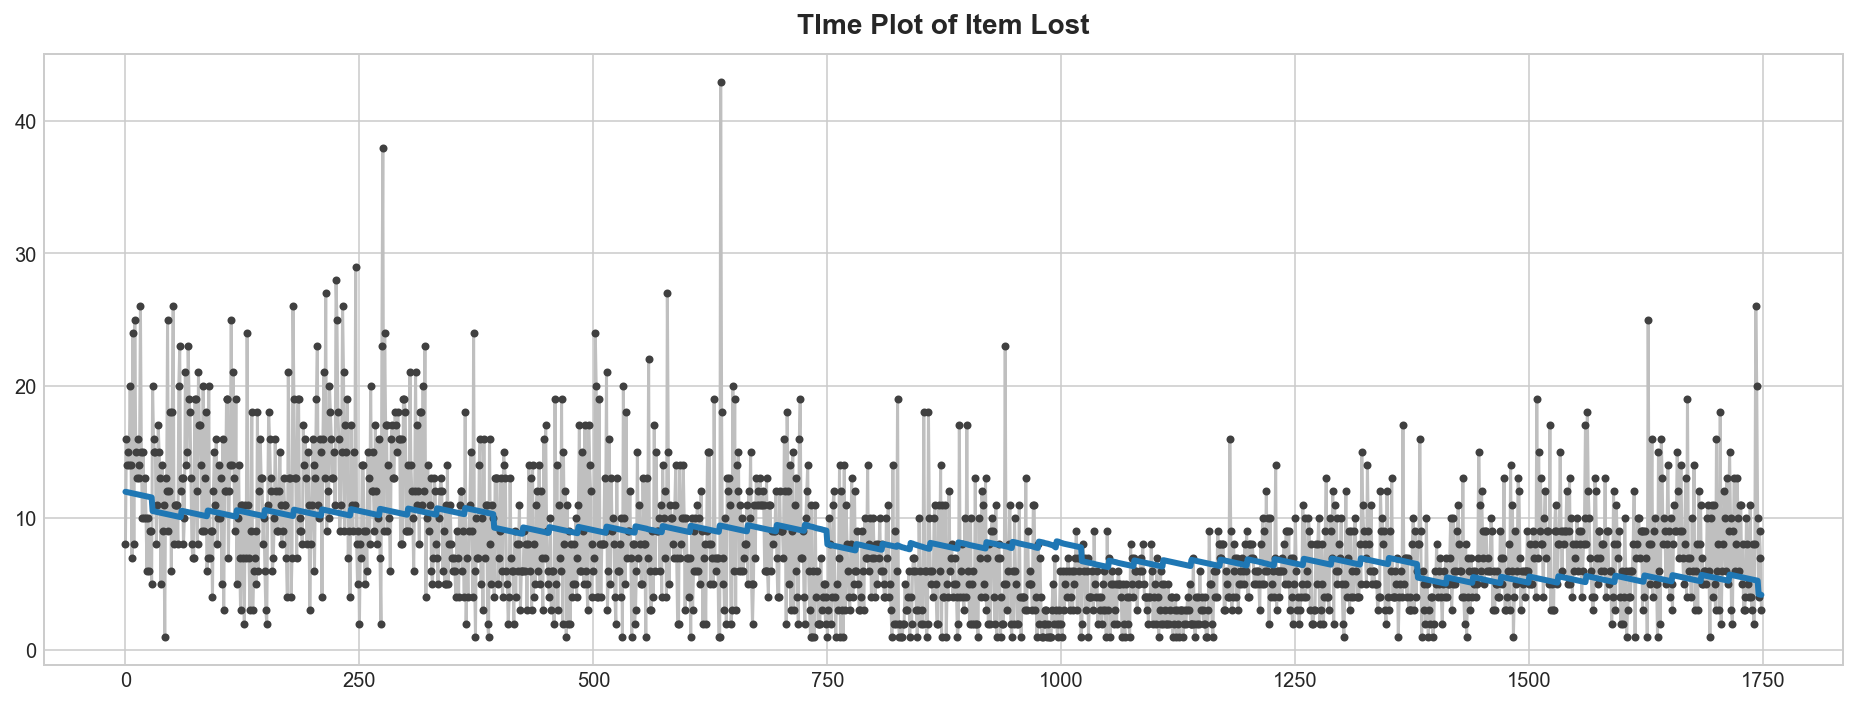

In [173]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")

plt.rc("figure", autolayout=True, figsize=(13, 5))

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('TIme Plot of Item Lost');

In [174]:
dfday['Lag_1'] = dfday['cnt'].shift(1)
dfday.head()

,year,month,day,cnt,Lag_1
0,2017,12,3,8,NaN
1,2017,12,4,16,8.0
2,2017,12,5,14,16.0
3,2017,12,6,15,14.0
4,2017,12,7,14,15.0


In [175]:
from sklearn.linear_model import LinearRegression

X = dfday.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = dfday.loc[:, 'cnt']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

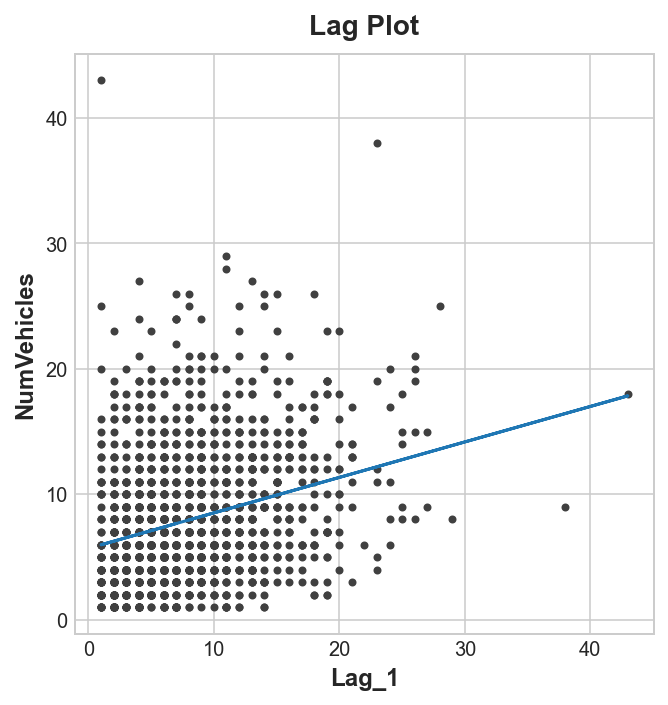

In [176]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot');

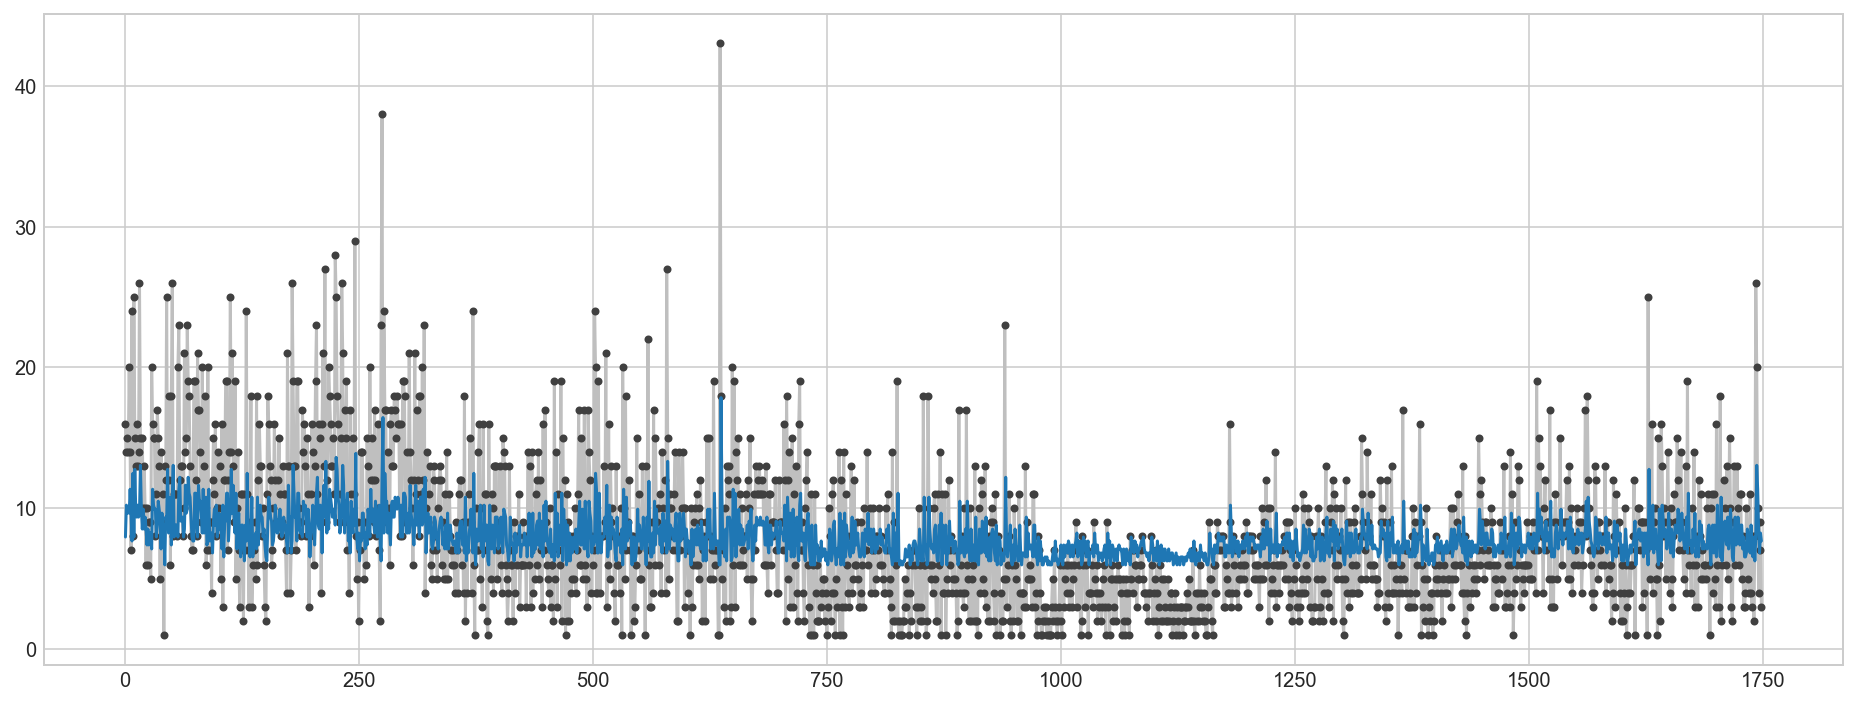

In [177]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

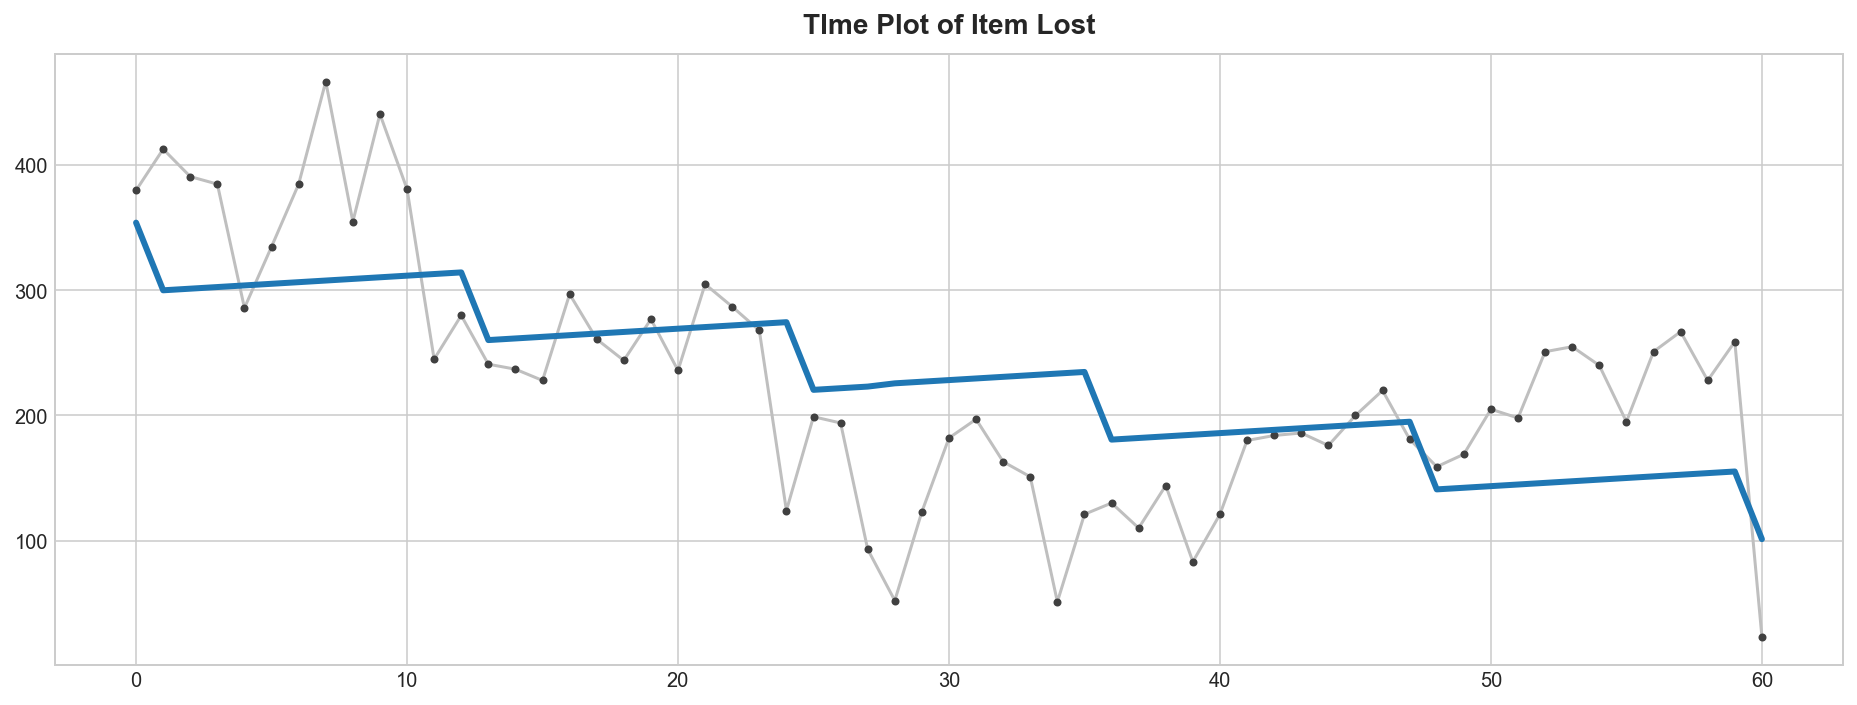

In [197]:
dfmonth = df.groupby(['year','month'])['cnt'].sum().reset_index()

# Training data
X = dfmonth.loc[:, ['year','month']]  # features
y = dfmonth.loc[:, 'cnt']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('TIme Plot of Item Lost');

In [198]:
dfmonth['Lag_1'] = dfmonth['cnt'].shift(1)
dfmonth.head()

,year,month,cnt,Lag_1
0,2017,12,380,NaN
1,2018,1,413,380.0
2,2018,2,391,413.0
3,2018,3,385,391.0
4,2018,4,286,385.0


In [199]:
from sklearn.linear_model import LinearRegression

X = dfmonth.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = dfmonth.loc[:, 'cnt']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

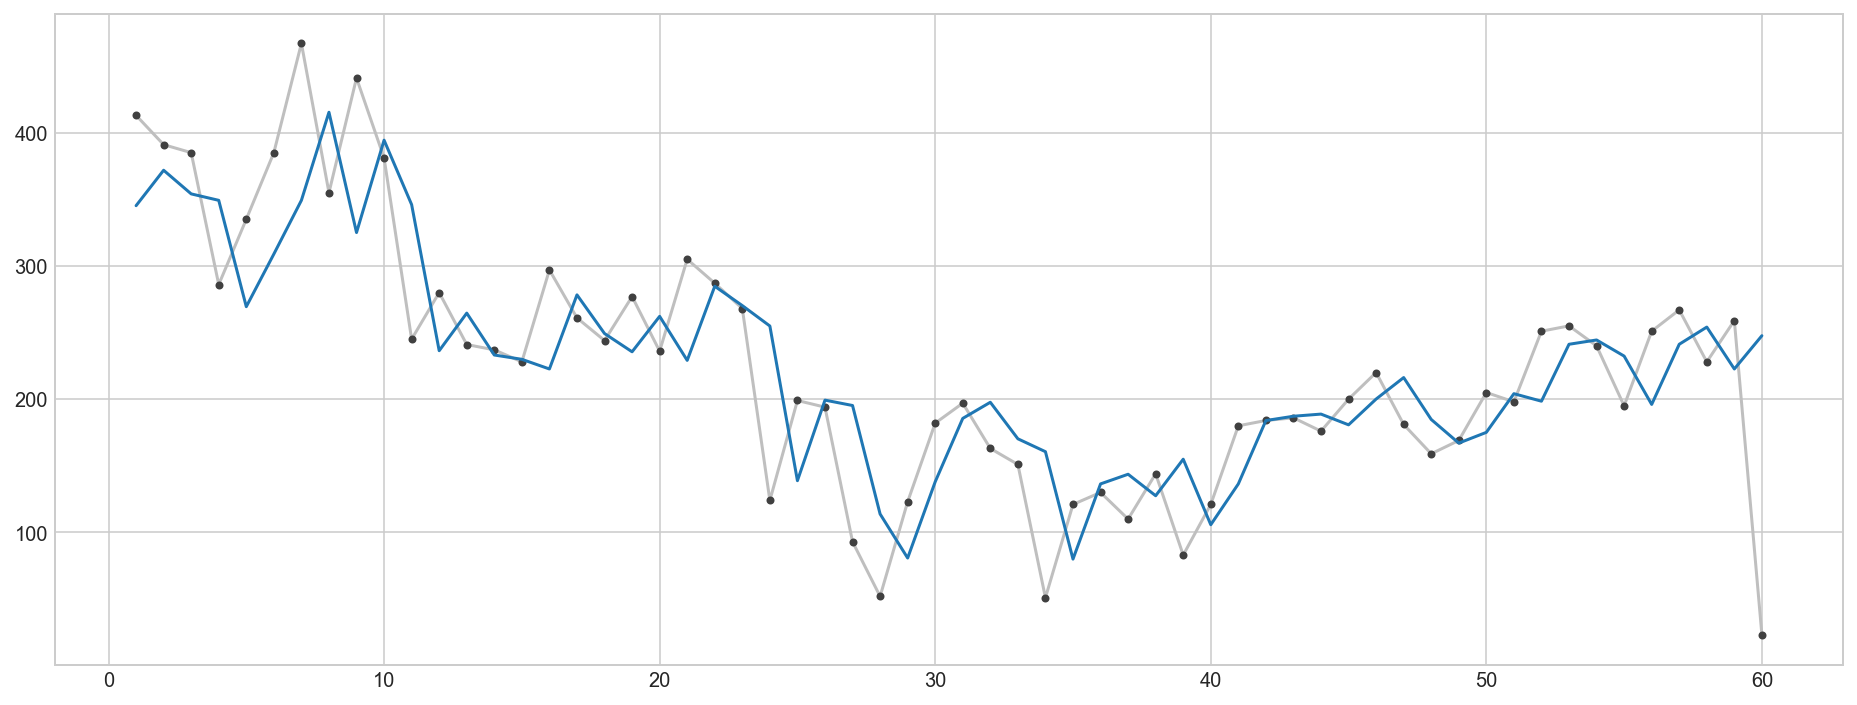

In [200]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [178]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(dfday[['cnt']], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12441.634, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11439.285, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11966.206, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11246.546, Time=1.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.92 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11751.117, Time=1.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11056.155, Time=2.26 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11241.342, Time=0.65 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.65 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.32 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=10949.073, Time=1.91 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [205]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(dfmonth[['cnt']], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=545.451, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=560.177, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=550.781, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=543.962, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=553.768, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=545.488, Time=0.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=544.861, Time=0.36 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=547.007, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=550.117, Time=0.08 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=545.273, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=547.909, Time=0.20 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=546.675, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=543.913, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   

In [206]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -267.956
Date:                            Wed, 04 Jan 2023   AIC                            543.913
Time:                                    14:02:49   BIC                            551.398
Sample:                                         0   HQIC                           546.741
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3494      2.208      1.517      0.129      -0.978       7.677
ma.L1         -0.6720      0.165     -4.085      0.000      -0.994      -0.350
ma.S.L12      -0.7958      0.618     -1.288      0.198      -2.006       0.415
sigma2      3266.2907   1782.490      1.832      0.067    -227.325    6759.906
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.57   Prob(JB):                         0.10
Heteroskedasticity (H):               1.17   Skew:                            -0.60
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [207]:
y_pred = stepwise_fit.predict(dfmonth.shape[0])

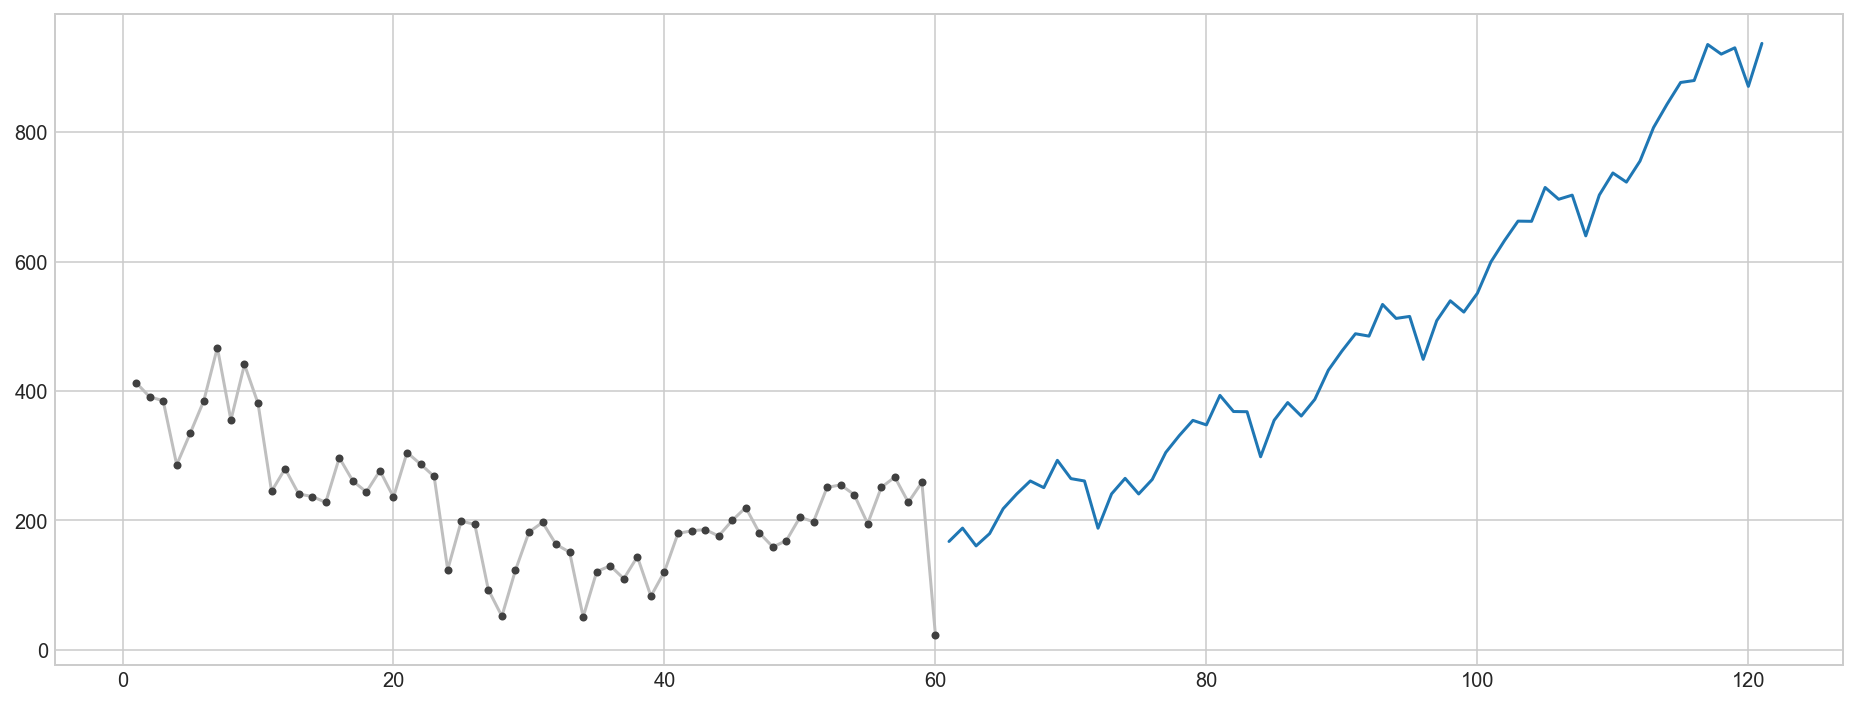

In [208]:
ax = y.plot(**plot_params)
ax = y_pred.plot()